# *PageRank* : de l'algorithme classique aux calculs distribués

Kim Antunez, Isabelle Bernard pour le projet d'*Elements Logiciels pour le Traitement de Données Massives* (2020-2021)


## Cadre d'analyse

*PageRank* est un algorithme, parmi d'autres, qui mesure la popularité d'une page web. Il fonctionne en classant les pages du Web en fonction de leur popularité (voir description détaillée en partie 1.2).

Il a été inventé par Larry Page [1], cofondateur de Google, et est utilisé par le moteur de recherche de l'entreprise. Il s'agit d'une marque déposée dont le premier brevet a été déposé en 1997. Jusqu'en 2016, les internautes pouvaient obtenir une approximation du classement de chaque page mais depuis, Google ne fournit plus cette valeur. 

###  Principe recherché par *PageRank*


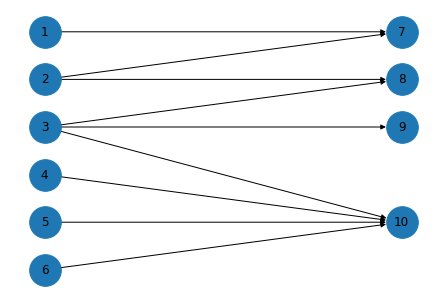

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_node(1,pos=(1,7))
G.add_node(2,pos=(1,6))
G.add_node(3,pos=(1,5))
G.add_node(4,pos=(1,4))
G.add_node(5,pos=(1,3))
G.add_node(6,pos=(1,2))
G.add_node(7,pos=(2,7))
G.add_node(8,pos=(2,6))
G.add_node(9,pos=(2,5))
G.add_node(10,pos=(2,3))
G.add_edges_from([(1, 7), (2, 7),(2, 8),(3, 8),(3, 9),(3, 10),(4, 10),(5, 10),(6, 10)])
nx.draw(G, nx.get_node_attributes(G,'pos'), with_labels=True, node_size=1000)
plt.show()

La modélisation adoptée utilise la théorie des graphes. Le web est un **graphe orienté** $G$ contient $N$ **noeuds** (pages, ici $N = 10$) reliés par des **liens** orientés (hyperliens). Un **degré entrant** (*in-degree*) d'une page correspond aux nombre d'hyperliens qui pointent sur elle et le **degré sortant** (*out-degree*) le nombre d'hyperliens vers lesquels elle pointe. 

Si l'on veut faire une première vulgarisation de l'algorithme, on peut dire que *PageRank* cherche à respecter les propriétés suivantes : 


1. **Popularité absolue** : plus le nombre de pages citant une page est grande, plus sa popularité doit être élevée. 

*Exemple : Dans la figure qui suit, le noeud $10$ est particulièrement populaire car 4 noeuds (les $3$, $4$, $5$ et $6$) pointent vers lui.*

2. **Popularité relative** : quand deux pages sont citées le même nombre de fois, c'est la page qui a été le plus cité en proportion par ses voisins qui doit être la plus populaire. 

*Exemple : On cherche à distinguer la popularité des noeuds $7$ et $8$ qui ont chacun deux noeuds qui pointent vers eux. On considère que le noeud $7$ est plus populaire car le noeud $1$ popularise exclusivement ce noeud, alors que le noeud $3$ popularise le noeud $8$ dans une moindre mesure car il popularise 2 autres noeuds ($9$ et $10$).* 

=> *PageRank* se rapproche d'une mesure de centralité sur le réseau du web. **Plus la page web a de chance d'être dans les premières positions lors d'une recherche sur internet, plus le *PageRank* sera élevé**. Son principe est d'attribuer à chaque page un score proportionnel au nombre de fois que passerait par cette page un utilisateur parcourant le graphe du Web en cliquant aléatoirement, sur un des liens apparaissant sur chaque page. Une page a un *PageRank* d'autant plus important qu'est grande la somme des *PageRanks* des pages qui pointent vers elle. 


### Algorithme de *PageRank* 

La valeur *PageRank* d'une page $p$ ($r(p)$) dépend des valeurs *PageRank* de chacune des pages $q$ qui pointent vers la page $p$ ($q \rightarrow p$) divisées par le nombre de noeuds auxquels fait référence la page $q$ ($d(q)$ : = degré sortant) : 

\begin{equation}
r(p)=\sum_{ q \rightarrow p}\frac{r(q)}{d(q)}
\end{equation}

L'équation peut être réécrite sous forme matricielle $\vec{r} = L \vec{r}$ où le vecteur $\vec{r}$ est le vecteurs des valeurs PageRank des $N$ pages et la matrice $L$ est telle que $L[i, j] = \frac{1}{d(i)}$ s'il y a un lien qui relit le noeud $i$ au noeud $j$ et qui vaut 0 sinon. 

Le programme de recherche de vecteur propre peut être résolu par l’algorithme de la puissance itérée (*power iteration method*) qui repose sur le théorème de Perron-Frobenius. Cet algorithme est utilisé dans le cas de PageRank en raison de la grande taille de la matrice qui encourage à utiliser la matrice au travers de produits, mais sa vitesse de convergence (convergence qui d'ailleurs n'est pas garantie) est assez lente. On stoppe donc l'algorithme après un certain nombre d'itérations ou si la norme L1 de l'écart des valeurs *PageRank* entre 2 itérations est inférieure à un certain seuil de tolérance qui dépend de $N$. 

### Approximation locale de *PageRank* 

La très grande taille de ce graphe et son évolution rendent coûteuses en opérations le calcul d'un *PageRank* pour une nouvelle page. C'est pourquoi des **algorithmes d'approximation** existent.

L'approximation locale de l'algorithme *PageRank* que nous utilisons s'appuie sur l'article [2]. 

Il s'agit d'approximer le vecteur des rangs de l'ensemble des pages en faisant un calcul itératif (marche aléatoire). Après avoir initialisé un rang de $\frac{1}{N}$ pour toutes les pages, on met à jour le vecteur de rangs de la manière suivante où $i$ correspond au numéro de l'itération : 

$$r^{i+1}(p)=\sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}$$

Cependant, dans cette formulation, si un noeud $p$ n'a pas de degré sortant $q$, c'est-à-dire qu'il ne fait référence à aucune page (*dangling node*), son rang n'est pas mis à jour dans l'algorithme à l'itération suivante, ce qui entraîne une perte de la valeur totale du *PageRank*. Une solution serait de nettoyer itérativement le graphe en enlevant les pages sans hyperliens. Mais, même en procédant ainsi, le graphe peut toujours contenir des groupes de pages très peu connectés entre eux qui posent le même problème. C'est pourquoi on introduit un facteur d'amortissement $\alpha$ (par exemple $\alpha = 0,85$, *teleportation factor*), et avec une probabilité $\alpha$ on réalise l'algorithme précédent (c'est-à-dire on choisit aléatoirement un degré sortant du noeud considéré) et avec la probabilité $1-\alpha$ (*damping factor*), on choisit un noeud au hasard : 

$$r^{i+1}(p)=\frac{1-\alpha}{N}+\alpha \sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}$$

<!-- Cet algorithme converge si le taux d'évolution du rang du noeud entre 2 itérations est petit et inférieur à un certain seuil $\varepsilon$ : 

$$\left | \frac{r^{i}(p) - r^{i-1}(p)}{r^{i-1}(p)} \right | < \varepsilon$$-->

### Approximation locale de *PageRank*  avec l'approche MapReduce avec Spark

Comme évoqué en cours d’ELTDM, **MapReduce**, inventé également par Google, permet d’effectuer des calculs parallèles, et souvent distribués, de données potentiellement très volumineuses, en les distribuant dans un cluster de machines.

Nous avons vu que l’algorithme *PageRank* est récursif, itératif, et dépend d’une structure de millions d’hyperliens. Le fait de l’implémenter sur une unique machine dont la mémoire doit disposer de l’ensemble du graphe le rend difficilement « scalable ». C’est pourquoi l’utilisation d’une structure en map-reduce se justifie largement ici. 

**Spark** est un framework open source qui permet de faire le calcul distribué dont nous avons besoin. Il réalise une lecture des données au niveau du cluster (grappe de serveurs sur un réseau), effectue toutes les opérations d'analyse nécessaires, puis écrit les résultats à ce même niveau. Il utilise pour cela un RDD, c'est-à-dire une collection de données calculée et conservée en mémoire vive. 

Grâce à la librairie python `pyspark` nous avons pu nous initier à cette technologie en l'utilisant sur nos PC en local. 


#### Version simplifiée

L’idée générale de *PageRank* est de **répandre** les masses de probabilités au fil de chaque flux d’**hyperliens sortants**. A la fin de chaque itération, chaque nœud est résumé par une valeur *PageRank* qui résume les fois où l’utilisateur navigant au hasard passe par la page (voir la figure 1 qui résume différentes itérations de l’algorithme dans le cas simplificateur où $\alpha = 0$). 

![Figure1](img/img1.png)

**Figure 1** : Schéma de l'algorithme *PageRank*

*Source : Lin, Dyer 2010*

L’implémentation MapReduce de PageRank est telle que chaque itération se décompose en 2 phases (cf. figure 2) : 
1. la phase « Map » : on sépare chaque nœud (page) associé à ses hyperliens
2. la phase « Reduce » : les contributions sont sommées pour tous les nœuds de destination

![Figure2](img/img2.png)

**Figure 2** : Schéma de l'algorithme *PageRank* avec l'approche MapReduce

*Source : Lin, Dyer 2010*

Cela se traduit algorithmiquement par le pseudo-code suivant : 

        classMapper
            method Map(nid n,node N)
            p← N.PageRank/|N.AdjacencyList|
            Emit(nidn,N) #Pass along graph structure
            for all nodeid m∈N. AdjacencyList do 
                Emit(nidm,p) #Pass PageRank mass to neighbors

        classReducer
            method Reduce(nid m,[p1,p2,...])
            M←∅
            for all p∈counts [p1,p2,...] do 
                if IsNode(p) then 
                    M←p #Recover graph structure
                else
                    s←s+p #Sum incoming PageRank contributions
            M.PageRank←s
            Emit(nid m,node M)
    
*Source : Lin, Dyer 2010*

#### Introduction du facteur $\alpha$

La modélisation se complique légèrement quand on considère le facteur $\alpha$ sans lequel la masse totale des valeurs *PageRank* ne seraient pas conservées en raison des *danding nodes*. Il s’agit alors simplement redistribuer (faire un nouveau mapping sur tous les nœuds) la masse perdue à l’ensemble des nœuds du graphe de manière égale. 

Mais il faut pour cela connaître la masse perdue. 3 options sont possibles : 

1.	passer par un compteur
2.	quand le *mapper*  rencontre un *danding node*, sa valeur PageRank est émise par une clef spéciale et le *reducer doit être modifié en conséquence. 
3.	condidérer la masse perdue comme des données « à part » et utiliser les méthodes d’aggregation *in-mapper*

Finalement, une itération de *PageRank* fait intervenir 2 processus MapReduce : 

1. Distribuer la masse PageRank tout au lond des hyperliens sortants
2. Faire attention aux *danding nodes* et introduire alors le paramètre $\alpha$

<!--Comme précédemment, on procède à des itérations jusqu’à obtenir convergence (modifications des *PageRank* faible entre 2 itérations. C’est pourquoi le *PageRank driver program* doit vérifier cette condition à la fin de chaque itération. -->

## Application


La base de données utilisée provient de la [librairie SNAP](http://snap.stanford.edu/data/index.html) de l'université de Stanford. Les données qui y sont mises à disposition l'ont été dans la plupart du temps dans des objectifs de recherche. 

Il s'agit du fichier `web-Google`, mis à disposition par Google en 2002 lors d'un concours de programmeurs, dont les 875 713 noeuds représentent des pages webs et les 5 105 039 liens orientés représentent les hyperliens. 

In [65]:
from pyspark import SparkContext, SparkConf
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from timeit import default_timer
%matplotlib inline
#%matplotlib notebook
from operator import add

### Fonctions utiles

Divers

In [678]:
def sauver_donnees(nb_lignes=60, fichier="web-Google"):
    if fichier=="web-Baidu":
        dfFile = pd.read_csv("data/{}.txt".format(fichier), sep=' ',
                             header=1, nrows = nb_lignes)
        nodesList = dfFile['#FromNodeId'].unique()
    else:
        dfFile = pd.read_csv("data/{}.txt".format(fichier), sep='\t',
                             header=3, nrows = nb_lignes)
        nodesList = dfFile['# FromNodeId'].unique()
        dfFile = dfFile[dfFile['ToNodeId'].isin(nodesList)] #enlever les donnees inutiles
    
    dfFile.to_csv("data/{}{}.txt".format(fichier, nb_lignes), sep=' ', header=False, index=False)

Les différents algorithmes de PageRank (global, local non distribué et distribué)

In [539]:
def pagerank_global(G, alpha=1, max_iter=100, tol=10000000000000000): 
  
    """Retourne : un dictionnaire de noeuds dont les valeurs correspondent aux PageRank     
  
    Paramètres
    ---------- 
    -G : graph (de type NetworkX) 
    -alpha : paramètre d'amortissement (0,85 par défaut) 
    -max_iter : nombre maximum d'itération dans la recherche de valeurs propres. 
    -tol : erreur de tolérence acceptée pour la convergence de la méthode de recherche des valeurs propres. 
     
    """
    
    start = default_timer()
    
    # Créer une copie sous forme de graphique droit-stochastique (pour chaque noeud, la somme des poids des liens sortant vaut 1)    
    W = nx.stochastic_graph(G, weight=None)
    N = W.number_of_nodes() 
  
    # Initialisation à 1/N 
    x = dict.fromkeys(W, 1.0 / N) 
    p = dict.fromkeys(W, 1.0 / N)
    dangling_weights = x 
    dangling_nodes = [n for n in W if W.out_degree(n, weight=None) == 0.0] 
    
    #algorithme de la puissance itérée
    for _ in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 
  
            # multiplication à gauche x^T=xlast^T*W 
            for nbr in W[n]: 
                x[nbr] += alpha * xlast[n] * W[n][nbr][None] 
            x[n] += danglesum * dangling_weights[n] + (1-alpha) * p[n] 
          
        # vérifier la convergence L1
        err = sum([abs(x[n] - xlast[n]) for n in x]) 
        if err < N*tol:
            duration = default_timer() - start
            #print(f'Le temps de calcul en secondes est de : {duration}, en minutes est de : {duration/60}')
            retour = (duration, x)
            return retour
    raise NetworkXError('pagerank: erreur de convergence au bout '
                        'de %d iterations.' % max_iter) 

In [540]:
def pagerank_local(G,nbIter=10,alpha=1, only_timer=False):  
    
    ### Initialisation
    # Lancer le chronomètre
    start = default_timer()
    # Successors and Predecessors
    successors = {node: list(G.successors(node)) for node in list(G.nodes())} 
    predecessors = {node: list(G.predecessors(node)) for node in list(G.nodes())}
    # Calcul du nombre total de noeuds (pages)
    N = G.number_of_nodes() 
    # Initialisation chacun des rangs à 1/N
    ranks = {node: 1.0/N for node in list(G.nodes())} 
    for i in range(nbIter):
        #r_sur_d = {node: float(ranks[node]/len(successors[node])) for node in list(G.nodes())}
        # Nouvelle version qui tient compte du bug de division par 0 (dangling nodes)
        #danglesum = alpha * sum(ranks[n] for n in dangling_nodes)
        danglesum = 0
        r_sur_d = {node :(float(1.0/N) if len(successors[node])==0
          else float(ranks[node]/len(successors[node]))) for node in list(G.nodes())}
        #print(r_sur_d)
        ranks_new = {node: danglesum/N +(1-alpha)/N + alpha * sum([r_sur_d[key] for key in predecessors[node]]) for node in list(G.nodes())}
        #print(sum(ranks_new.values()))
        ranks = ranks_new
    duration = default_timer() - start
    #print(f'Temps de calcul : {duration} sec., {duration/60} min.')
    if only_timer:
        retour=duration
    else:
        retour=(duration, ranks)
    return retour

In [541]:
# Récupère un noeud entrant et son noeud sortant et les met dans une liste. 
def ligne_vers_node(ligne):
    nodes = ligne.split(' ') 
    return int(nodes[0]), int(nodes[1])

def pagerank_local_spark(RddDataBase,nbIter=10,alpha=1,only_timer=False):   
    ### Initialisation
    # Lancer le chronomètre
    start = default_timer()
    # Créer l'association des paires clef/valeur
    # Clef : noeud. valeur : noeuds vers lesquels ils pointent (outlinks)
    # distinct : on cherche la liste unique des noeuds.
    # groupByKey : on groupe par noeud et on regarde les noeuds sortants
    links = RddDataBase.map(lambda ligne: ligne_vers_node(ligne))\
    .distinct().groupByKey().cache()
    # Calcul du nombre total de noeuds (pages)
    N = links.count() #Ne compte pas les dandling nodes !
    #print(N)
    # Initialisation chacun des rangs à 1/N
    ranks = links.map(lambda node: (node[0],1.0/N))
    #print(ranks)
    ## MapReduce = mise à jour itérative des rangs
    ### étape répétée jusqu'à ce que le nombre d'itérations soit atteint. 
    
    for i in range(nbIter):
    # MAP = floatMap : Calculer pour chaque noeud p les ratios Rq/Dq 
    #(float(x[1][1])/len(x[1][0])) des noeuds q sortants de p.
        new_ranks = links.join(ranks)\
                    .flatMap(lambda x : [(i, float(x[1][1])/len(x[1][0]))\
                                         for i in x[1][0]])  
        #print(new_ranks.sortByKey().collect())
        # REDUCE = reduceByKey : Pour chaque noeud p, sommer les valeurs associées 
    # aux noeuds entrants et mettre à jour les rangs.
        #ranks = ranks.reduceByKey(lambda x,y: x+y) #without alpha
        new_ranks = new_ranks.reduceByKey(add).mapValues(lambda rank: rank * alpha + (1-alpha)/N)  
        #print(sum({row[0]: row[1]  for row in new_ranks.collect()}.values()))
        ranks=new_ranks
        
    ### Temps de calcul et affichage du résultat
    duration = default_timer() - start
    #print(f'Temps de calcul : {duration} sec., {duration/60} min.')
    if only_timer:
        retour=duration
    else:
        retour=(duration, {row[0]: row[1]  for row in ranks.sortByKey().collect()}) #ranks.sortByKey().collect()
    return retour

Graphiques

In [704]:
def creer_donnees_graphique_timer_lignes(nbs_lignes,nb_iter,fichier="web-Google"):
    without_spark_list=[]
    with_spark_list=[]
    for nb_lignes in nbs_lignes: 
        df = pd.read_csv("data/{}{}.txt".format(fichier,nb_lignes),
                     sep=' ', names=["in","out"])
        G=nx.from_pandas_edgelist(df, 'in', 'out',create_using=nx.DiGraph())
        RddDataBase = sc.textFile("data/{}{}.txt".format(fichier,nb_lignes))
        without_spark = pagerank_local(G,nbIter=5,
                                            alpha=0.85, only_timer=True)
        without_spark_list.append(without_spark)
        with_spark = pagerank_local_spark(RddDataBase,nbIter=5,
                                               alpha=0.85, only_timer=True)
        with_spark_list.append(with_spark)
    return(with_spark_list,without_spark_list)

def creer_graphique_timer_lignes(nbs_lignes,with_spark_list,without_spark_list,nb_iter):    
    ax = plt.subplot()
    plt.plot(nbs_lignes,with_spark_list , label="Avec Spark")
    plt.plot(nbs_lignes,without_spark_list , label="Sans Spark")
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    plt.title("Temps d'exécution de l'algorithme ({} itérations) en fonction de la taille du fichier".format(nb_iter))
    plt.ylabel("Temps d'exécution (secondes)")
    plt.xlabel('Taille du fichier')
    #plt.savefig('Output/name.png')
    plt.show()

In [705]:
def creer_donnees_graphique_timer_iters(nbs_iters,nb_lignes,fichier="web-Google"):
    without_spark_list=[]
    with_spark_list=[]
    for nb_iters in nbs_iters: 
        df = pd.read_csv("data/{}{}.txt".format(fichier,nb_lignes),
                     sep=' ', names=["in","out"])
        G=nx.from_pandas_edgelist(df, 'in', 'out',create_using=nx.DiGraph())
        RddDataBase = sc.textFile("data/{}{}.txt".format(fichier,nb_lignes))
        without_spark = pagerank_local(G,nbIter=nb_iters,
                                            alpha=0.85, only_timer=True)
        without_spark_list.append(without_spark)
        with_spark = pagerank_local_spark(RddDataBase,nbIter=nb_iters,
                                               alpha=0.85, only_timer=True)
        with_spark_list.append(with_spark)
    return(with_spark_list,without_spark_list)

def creer_graphique_timer_iters(nbs_iters,with_spark_list,without_spark_list,nb_lignes):    
    ax = plt.subplot()
    plt.plot(nbs_iters,with_spark_list , label="Avec Spark")
    plt.plot(nbs_iters,without_spark_list , label="Sans Spark")
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    plt.title("Temps d'exécution de l'algorithme en fonction du nombre d'itérations")
    plt.ylabel("Temps d'exécution (secondes)")
    plt.xlabel("Nombre d'itérations")
    #plt.savefig('Output/name.png')
    plt.show()

### Petites données (100 lignes)

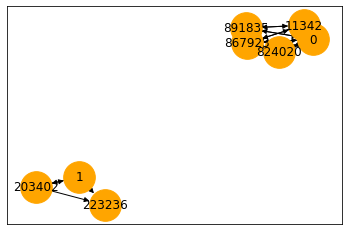

In [710]:
#sauver_donnees(nb_lignes=100, fichier="web-Google") 

#Représentation graphique des noeuds (pages) et des liens entre ces noeuds (pages)
fichier = "web-Google"
nb_lignes = 100
df1 = pd.read_csv("data/{}{}.txt".format(fichier,nb_lignes),
                  sep=' ', names=["in","out"])
G1=nx.from_pandas_edgelist(df1, 'in', 'out',create_using=nx.DiGraph())
nx.draw_networkx(G1, node_color = 'orange', node_size = 1000,arrows=True)
#plt.savefig('graph/graph_nodes_test.png')

Dans cet exemple il y a un *dangling node* (223236). Un *dandling node* $q$ n'a de lien sortant vers aucun individu, et son ratio $\frac{r^{i}(q)}{d(q)}$ faut l'infini puisque $d(q)=0$.

Dans ce cas, on doit normalement fixer le ratio à $0$ et rééquilibrer le poids des autres noeuds pour que la somme des rangs soit toujours égale à 1. Ici, pour simplifier les calculs et améliorer la vitesse de l'algorithme, nous retirons ce noeud. 

In [711]:
dangling_nodes = [n for n in G1 if G1.out_degree(n, weight=None) == 0.0] 
print(dangling_nodes)
G1.remove_nodes_from(dangling_nodes) #car méthode ne gère pas dandling nodes

[223236]


In [712]:
# Connexion au cluster / test en local
spark_conf = SparkConf()\
    .setAppName('Page Rank With PySpark')\
    .setMaster('local')
sc.stop()
sc = SparkContext(conf=spark_conf)

#Partitionner les données pour Spark
RddDataBase = sc.textFile("data/{}{}.txt".format(fichier,nb_lignes))

**PageRank global**

In [713]:
print(pagerank_global(G1, alpha=1, max_iter=2))
print(pagerank_global(G1, alpha=0.85, max_iter=2))

(0.00026509999952395447, {0: 0.19047619047619047, 11342: 0.13095238095238093, 824020: 0.03571428571428571, 867923: 0.17857142857142855, 891835: 0.17857142857142855, 1: 0.14285714285714285, 203402: 0.14285714285714285})
(0.0002167999991797842, {0: 0.18333333333333332, 11342: 0.1327380952380952, 824020: 0.05178571428571428, 867923: 0.1732142857142857, 891835: 0.1732142857142857, 1: 0.14285714285714285, 203402: 0.14285714285714285})


**PageRank local non distribué**

In [714]:
print(pagerank_local(G1,nbIter=2,alpha=1))
print(pagerank_local(G1,nbIter=2,alpha=0.85))

(8.209999941755086e-05, {0: 0.17460317460317457, 11342: 0.16666666666666663, 824020: 0.047619047619047616, 867923: 0.16269841269841268, 891835: 0.16269841269841268, 1: 0.14285714285714285, 203402: 0.14285714285714285})
(0.0001706000002741348, {0: 0.17186507936507936, 11342: 0.15854166666666666, 824020: 0.06038690476190477, 867923: 0.16174603174603172, 891835: 0.16174603174603172, 1: 0.14285714285714285, 203402: 0.14285714285714285})


**PageRank local distribué**

In [715]:
print(pagerank_local_spark(RddDataBase,nbIter=2,alpha=1))
print(pagerank_local_spark(RddDataBase,nbIter=2,alpha=0.85))

(2.4938419999998587, {0: 0.1746031746031746, 1: 0.03571428571428571, 11342: 0.16666666666666663, 203402: 0.03571428571428571, 223236: 0.07142857142857142, 824020: 0.047619047619047616, 867923: 0.16269841269841268, 891835: 0.16269841269841268})
(2.4405566999994335, {0: 0.17186507936507936, 1: 0.05633928571428572, 11342: 0.15854166666666666, 203402: 0.05633928571428572, 223236: 0.09125000000000001, 824020: 0.06038690476190477, 867923: 0.16174603174603172, 891835: 0.16174603174603172})


### Graphiques de mesure de performance

#### Avec Web-Google

In [580]:
spark_conf = SparkConf()\
    .setAppName('Page Rank With PySpark')\
    .setMaster('local')
sc.stop()
sc = SparkContext(conf=spark_conf)

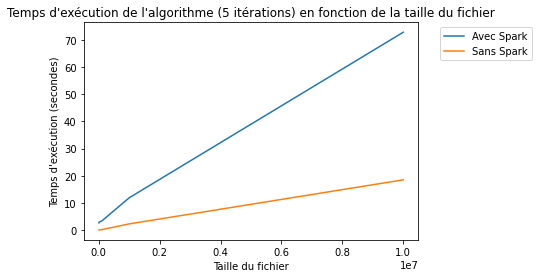

In [593]:
nbs_lignes=[1000,10000,100000,1000000,10000000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_lignes(
    nbs_lignes,
    nb_iter=5)
creer_graphique_timer(nbs_lignes,with_spark_list,without_spark_list,nb_iter=5)

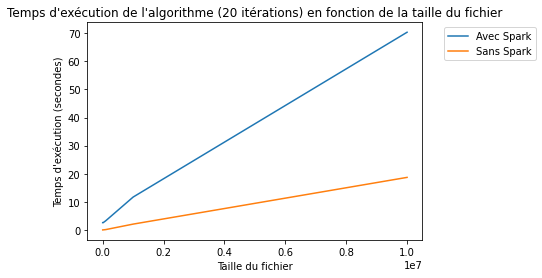

In [597]:
nbs_lignes=[1000,10000,100000,1000000,10000000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_lignes(
    nbs_lignes,
    nb_iter=20)
creer_graphique_timer(nbs_lignes,with_spark_list,without_spark_list,nb_iter=20)

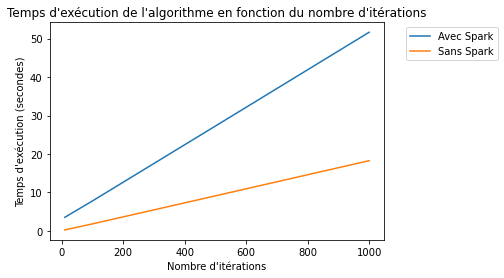

In [613]:
nbs_iters=[10,100,500,1000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_iters(
    nbs_iters,nb_lignes=100000)
creer_graphique_timer_iters(nbs_iters,with_spark_list,
                            without_spark_list,nb_lignes=100000)

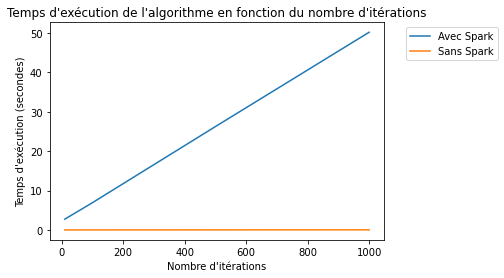

In [614]:
nbs_iters=[10,100,500,1000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_iters(
    nbs_iters,nb_lignes=100)
creer_graphique_timer_iters(nbs_iters,with_spark_list,
                            without_spark_list,nb_lignes=100)

#### Avec Web-Stanford (à suppr au prochain commit)

J'ai testé au cas où ça dépend des données... J'ai pas trouvé de données concluantes hélas.

In [699]:
sauver_donnees(nb_lignes=10000000, fichier="web-Stanford") 
#1000,10000,100000,1000000,10000000

In [700]:
spark_conf = SparkConf()\
    .setAppName('Page Rank With PySpark')\
    .setMaster('local')
sc.stop()
sc = SparkContext(conf=spark_conf)

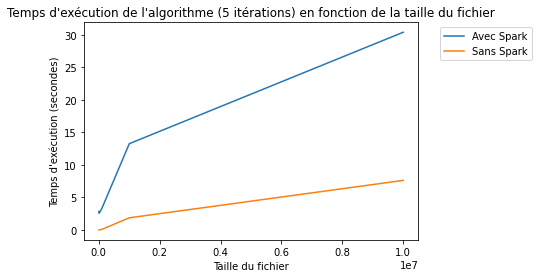

In [706]:
nbs_lignes=[1000,10000,100000,1000000,10000000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_lignes(
    nbs_lignes,
    nb_iter=5, fichier="web-Stanford")
creer_graphique_timer(nbs_lignes,
                      with_spark_list,without_spark_list,nb_iter=5)

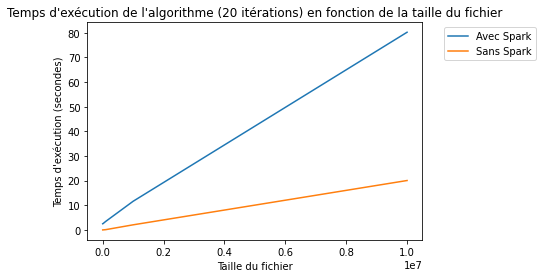

In [707]:
nbs_lignes=[1000,10000,100000,1000000,10000000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_lignes(
    nbs_lignes,
    nb_iter=20)
creer_graphique_timer(nbs_lignes,with_spark_list,without_spark_list,nb_iter=20)

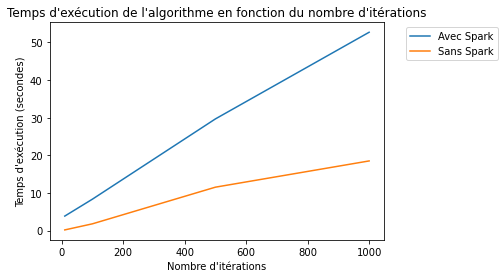

In [708]:
nbs_iters=[10,100,500,1000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_iters(
    nbs_iters,nb_lignes=100000)
creer_graphique_timer_iters(nbs_iters,with_spark_list,
                            without_spark_list,nb_lignes=100000)

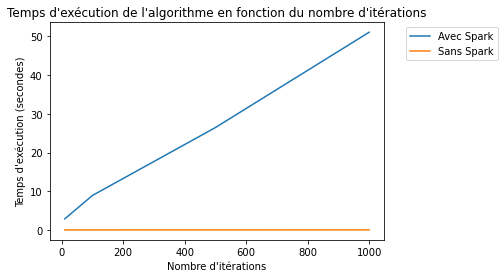

In [709]:
nbs_iters=[10,100,500,1000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_iters(
    nbs_iters,nb_lignes=100)
creer_graphique_timer_iters(nbs_iters,with_spark_list,
                            without_spark_list,nb_lignes=100)

## Bibliographie 

[1] S. Brin and L. Page. The anatomy of a large-scalehypertextual web search engine. InProc. of theSeventh World Wide Web Conference, 1998.

[2] Z.Bar-Yossefet L.T.Mashiach. « Local Approximation of PageRank and Reverse Page-Rank ». In :CIKM(oct. 2008).

[3]  Q. GanY. Chenet T.Suel. « Local methods for estimating PageRank values ». In :CIKM(2004), 381–38

[4] Bahmani, B., Chowdhury, A., & Goel, A. (2010). Fast incremental and personalized pagerank. arXiv preprint arXiv:1006.2880.

[5] Lin, J., & Dyer, C. (2010). Data-intensive text processing with MapReduce. Synthesis Lectures on Human Language Technologies, 3(1), 1-177. (à partir de la page 106)

http://www.economiematin.fr/news-algorythme-page-rank-popularite-web

https://www.geeksforgeeks.org/page-rank-algorithm-implementation/

http://www.bibmath.net/dico/index.php?action=affiche&quoi=./p/perron-frobenius.html

https://univalence.io/blog/articles/shuffle-dans-spark-reducebykey-vs-groupbykey/

# Brouillon Kim à supprimer à la fin

Tentative de gestion des dangling node

In [ ]:
#non aboutie
def pagerank1_local_spark(RddDataBase,nbIter=10,alpha=1,only_timer=False):   
    ### Initialisation
    # Lancer le chronomètre
    start = default_timer()
    # Créer l'association des paires clef/valeur
    # Clef : noeud. valeur : noeuds vers lesquels ils pointent (outlinks)
    # distinct : on cherche la liste unique des noeuds.
    # groupByKey : on groupe par noeud et on regarde les noeuds sortants
    links = RddDataBase.map(lambda ligne: ligne_vers_node(ligne))\
    .distinct().groupByKey().cache()
    # Calcul du nombre total de noeuds (pages)
    N = links.count() #Ne compte pas les dandling nodes !
    print(N)
    # Initialisation chacun des rangs à 1/N
    ranks = links.map(lambda node: (node[0],1.0/N))
    print(ranks)
    ## MapReduce = mise à jour itérative des rangs
    ### étape répétée jusqu'à ce que le nombre d'itérations soit atteint. 
    
    for i in range(nbIter):
    # MAP = floatMap : Calculer pour chaque noeud p les ratios Rq/Dq 
    #(float(x[1][1])/len(x[1][0])) des noeuds q sortants de p.
        # Tentative dangling sum
        #danglingnodes = links.map(lambda node: (node[0] if node[1]==0 else None))
        danglingnodes = links.map(lambda node: list(node[1]))
        print(danglingnodes.collect())
    
        danglingsum = 1
        #old
        new_ranks = links.join(ranks)\
                    .flatMap(lambda x : [(i, float(x[1][1])/len(x[1][0]))\
                                         for i in x[1][0]])  
        print(new_ranks.sortByKey().collect())
        # Tentative dangling nodes
        new_ranks = links.join(ranks)\
                    .flatMap(lambda x : [(i, float(1.0/N) if len(x[1][0])==0 else float(x[1][1])/len(x[1][0])) for i in x[1][0]])  
        
        print(new_ranks.sortByKey().collect())
        # REDUCE = reduceByKey : Pour chaque noeud p, sommer les valeurs associées 
    # aux noeuds entrants et mettre à jour les rangs.
        #ranks = ranks.reduceByKey(lambda x,y: x+y) #without alpha
        new_ranks = new_ranks.reduceByKey(add).mapValues(lambda rank: rank * alpha + (1-alpha)/N)  
        print(sum({row[0]: row[1]  for row in new_ranks.collect()}.values()))
        
        #Tentative dangling nodes
        new_ranks = new_ranks.reduceByKey(add).mapValues(lambda rank: danglingsum/N + rank * alpha + (1-alpha)/N)  
        print(sum({row[0]: row[1]  for row in new_ranks.collect()}.values()))
        
        ranks=new_ranks
        
    ### Temps de calcul et affichage du résultat
    duration = default_timer() - start
    #print(f'Temps de calcul : {duration} sec., {duration/60} min.')
    if only_timer:
        retour=duration
    else:
        retour=(duration, {row[0]: row[1]  for row in ranks.sortByKey().collect()}) #ranks.sortByKey().collect()
    return retour

In [ ]:
def pagerank1_local(G,nbIter=10,alpha=1, only_timer=False):   
    ### Initialisation
    # Lancer le chronomètre
    start = default_timer()
    # Calcul du nombre total de noeuds (pages)
    N = G.number_of_nodes() 
    # Successors and Predecessors
    successors = {node: list(G.successors(node)) for node in list(G.nodes())} 
    predecessors = {node: list(G.predecessors(node)) for node in list(G.nodes())}
    # Initialisation chacun des rangs à 1/N
    ranks = {node: 1.0/N for node in list(G.nodes())} 
    # Dandling nodes 
    dangling_nodes = [n for n in G if G.out_degree(n, weight=None) == 0.0] 
    for i in range(nbIter):
        #r_sur_d = {node: float(ranks[node]/len(successors[node])) for node in list(G.nodes())}
        # Nouvelle version qui tient compte du bug de division par 0 (dangling nodes)
        danglesum = alpha * sum(ranks[n] for n in dangling_nodes)
        #print(danglesum)
        r_sur_d = {node :(float(1.0/N) if len(successors[node])==0
          else float(ranks[node]/len(successors[node]))) for node in list(G.nodes())}
        #print(r_sur_d)
        ranks_new = {node: danglesum/N +(1-alpha)/N + alpha * sum([r_sur_d[key] for key in predecessors[node]]) for node in list(G.nodes())}
        #print(sum(ranks_new.values()))
        ranks = ranks_new
    duration = default_timer() - start
    #print(f'Temps de calcul : {duration} sec., {duration/60} min.')
    if only_timer:
        retour=duration
    else:
        retour=(duration, ranks)
    return retour